# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
'''
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('dev data shape: ', X_dev.shape)
print ('dev labels shape: ', y_dev.shape)
'''

"\nprint('Train data shape: ', X_train.shape)\nprint('Train labels shape: ', y_train.shape)\nprint ('Validation data shape: ', X_val.shape)\nprint ('Validation labels shape: ', y_val.shape)\nprint ('Test data shape: ', X_test.shape)\nprint ('Test labels shape: ', y_test.shape)\nprint ('dev data shape: ', X_dev.shape)\nprint ('dev labels shape: ', y_dev.shape)\n"

## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.422681
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *The initial weight is close to 0. Thus the scores for each class are all 1s.
So the loss function is close to -log(0.1)*


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)
print('----------------gorgeous seperation line--------------------')
# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.589608 analytic: 1.589608, relative error: 1.344659e-08
numerical: -4.443609 analytic: -4.443609, relative error: 7.003963e-09
numerical: 2.044606 analytic: 2.044606, relative error: 2.866104e-08
numerical: -2.260243 analytic: -2.260243, relative error: 1.133648e-08
numerical: -0.416489 analytic: -0.416489, relative error: 4.920356e-08
numerical: -4.760792 analytic: -4.760792, relative error: 6.376950e-09
numerical: -4.305273 analytic: -4.305273, relative error: 1.108620e-08
numerical: -2.877109 analytic: -2.877109, relative error: 8.748087e-09
numerical: 2.725031 analytic: 2.725031, relative error: 8.543808e-09
numerical: -1.374046 analytic: -1.374046, relative error: 3.761696e-08
----------------gorgeous seperation line--------------------
numerical: -1.000896 analytic: -1.000896, relative error: 8.019947e-08
numerical: 0.506804 analytic: 0.506804, relative error: 6.576361e-09
numerical: 1.234393 analytic: 1.234393, relative error: 3.403301e-09
numerical: -0.226428 analy

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print ('Gradient difference: %f' % grad_difference)

naive loss: 2.422681e+00 computed in 0.106589s
vectorized loss: 2.422681e+00 computed in 0.546917s
Loss difference: 0.000000
Gradient difference: 0.000000


In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

lost_hist_group = {}
for lr in range(2):
    for rs in range(2):
        tune_softmax = Softmax()
        
        lost_hist_group[lr,rs] = tune_softmax.train(X_train, y_train, learning_rate=learning_rates[lr], 
                  reg=regularization_strengths[rs],
                      num_iters=1500, verbose=False)
        
        y_train_pred_tune = tune_softmax.predict(X_train)
        y_val_pred_tune = tune_softmax.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred_tune)
        val_accruary = np.mean(y_val == y_val_pred_tune)
        results.update({(learning_rates[lr], regularization_strengths[rs])
                        : (train_accuracy, val_accruary)})
        if val_accruary > best_val:
            best_val = val_accruary
            best_softmax = tune_softmax
    

pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

C:\Users\wkcw\Desktop\stanford-cs231n\assignment1\cs231n\classifiers\softmax.py:138: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum( W*W )
C:\Users\wkcw\Desktop\stanford-cs231n\assignment1\cs231n\classifiers\softmax.py:138: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum( W*W )
C:\Users\wkcw\Desktop\stanford-cs231n\assignment1\cs231n\classifiers\softmax.py:140: RuntimeWarning: overflow encountered in multiply
  dW += reg * W


lr 1.000000e-07 reg 5.000000e+02 train accuracy: 0.252673 val accuracy: 0.254000
lr 1.000000e-07 reg 1.000000e+08 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-07 reg 5.000000e+02 train accuracy: 0.345408 val accuracy: 0.342000
lr 5.000000e-07 reg 1.000000e+08 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.342000


iteration 0 / 3000: loss 768.502566
iteration 100 / 3000: loss 282.437623
iteration 200 / 3000: loss 104.704252
iteration 300 / 3000: loss 39.596079
iteration 400 / 3000: loss 15.930948
iteration 500 / 3000: loss 7.055427
iteration 600 / 3000: loss 3.931019
iteration 700 / 3000: loss 2.784525
iteration 800 / 3000: loss 2.346948
iteration 900 / 3000: loss 2.121884
iteration 1000 / 3000: loss 2.169007
iteration 1100 / 3000: loss 2.147364
iteration 1200 / 3000: loss 2.172815
iteration 1300 / 3000: loss 2.050299
iteration 1400 / 3000: loss 2.123902
iteration 1500 / 3000: loss 2.071999
iteration 1600 / 3000: loss 2.087370
iteration 1700 / 3000: loss 2.138846
iteration 1800 / 3000: loss 2.070420
iteration 1900 / 3000: loss 2.128243
iteration 2000 / 3000: loss 2.067251
iteration 2100 / 3000: loss 2.115887
iteration 2200 / 3000: loss 2.146878
iteration 2300 / 3000: loss 2.104827
iteration 2400 / 3000: loss 2.111150
iteration 2500 / 3000: loss 2.080261
iteration 2600 / 3000: loss 2.122416
itera

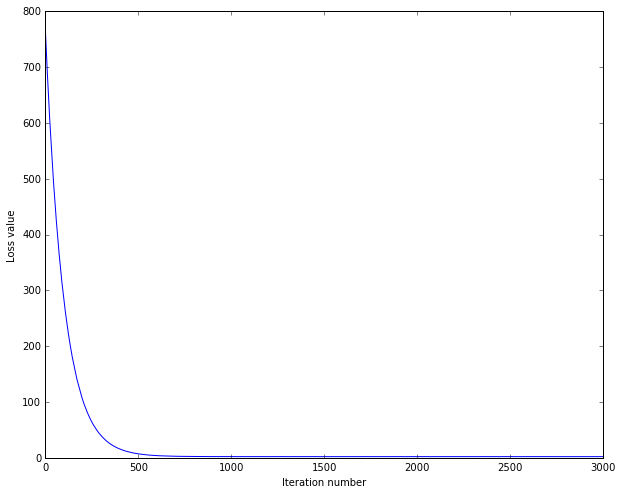

In [12]:
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=3000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
y_train_pred_tune = softmax.predict(X_train)
y_val_pred_tune = softmax.predict(X_val)
train_accuracy = np.mean(y_train == y_train_pred_tune)
val_accuracy = np.mean(y_val == y_val_pred_tune)
print('train accuracy:',train_accuracy)
print('val accuracy:',val_accuracy)

train accuracy: 0.327244897959
val accuracy: 0.343


In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.339000


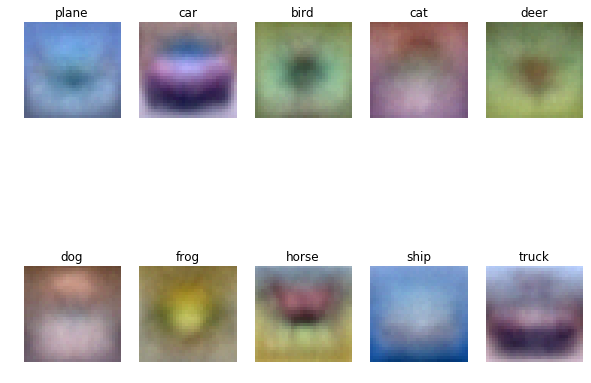

In [10]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])